In [69]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)

set_seed(1)

In [70]:
def prepare_data(dataset_path_train = None,dataset_path_test = None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    train = pd.read_csv(dataset_path_train)
    test = pd.read_csv(dataset_path_test)
    
    y_train = train['label']
    y_test = test['label']
    
    X_train = train[['roberta_prediction', 'text']]
    X_test = test[['roberta_prediction', 'text']]
    
    return X_train, y_train, X_test, y_test

def prepare_lex_data(dataset_path_train = None,dataset_path_test = None):
    if (dataset_path_train is None or dataset_path_test is None):
        raise RuntimeException("Error! Dataset must be provided")
    train = pd.read_csv(dataset_path_train)
    test = pd.read_csv(dataset_path_test)
    
    y_train = train['label']
    y_test = test['label']
    
    features = []
    for feat in train.columns.values:
        if 'lex' in feat:
            features.append(feat)
    features.extend(['roberta_prediction', 'syntax_ari', 'social_karma'])
    
    X_train = train[features]
    X_test = test[features]
    
    return X_train, y_train, X_test, y_test

def evaluate(test_labels, y_pred):
    acc = accuracy_score(test_labels, y_pred)
    rec = recall_score(test_labels, y_pred, zero_division=1)
    prec = precision_score(test_labels, y_pred, zero_division=1)
    f1 = f1_score(test_labels, y_pred, zero_division=1)
    print("Accuracy: ", acc)
    print("Recall: ", rec)
    print("Precision: ", prec)
    print("F1: ", f1)

In [71]:
from empath import Empath
lexicon = Empath()

def empath(X):
    rows = []
    for t in X['text']:
        empath = lexicon.analyze(t, normalize=True)
        rows.append(pd.DataFrame([empath]))
    df = pd.concat(rows, ignore_index=True)
    X = pd.concat([X,df], axis=1)
    return X.drop(columns=['text'])

In [72]:
X_train, y_train, X_test, y_test = prepare_data(dataset_path_train = 'train_pred_mental_health.csv', dataset_path_test = 'test_pred_mental_health.csv')
X_train = empath(X_train)
X_test = empath(X_test)

In [73]:
import phik
def pairs(X, threshold):
    corr =  X.phik_matrix(interval_cols=X.columns)
    columns = corr.columns
    high_corr = dict()
    feature_corr_n = dict.fromkeys(X.columns, 0)
    for column1 in columns:
        for column2 in columns:
            value = corr[column1][column2]
            if value > threshold and column1 != column2 and (column2, column1) not in high_corr:
                high_corr[(column1,column2)] = value
    return high_corr

In [74]:
def cutoff_features(threshold, X):
    corr_matrix =  X.phik_matrix(interval_cols=X.columns)
    upper_tri = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > float(threshold))]
    return to_drop
to_drop = cutoff_features(0.85, X_train)

In [75]:
to_drop

['health',
 'banking',
 'night',
 'college',
 'exasperation',
 'reading',
 'worship',
 'eating',
 'water',
 'legend',
 'neglect',
 'swimming',
 'love',
 'sympathy',
 'vehicle',
 'disgust',
 'sound',
 'sailing',
 'warmth',
 'fun',
 'joy',
 'affection',
 'lust',
 'shame',
 'anger',
 'car',
 'technology',
 'power',
 'white_collar_job',
 'party',
 'cleaning',
 'competing',
 'ocean',
 'contentment',
 'musical']

In [76]:
X_train = X_train.drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler

hp = {
        'solver': ['liblinear', 'newton-cg', 'lbfgs'],
        'penalty': ['l2', 'elasticnet'],
        'C': [0.1, 1, 10],
}

sclr = StandardScaler()
X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.transform(X_test)
gs_model = GridSearchCV(LogisticRegression(max_iter=1000000), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train_s, y_train)

model = LogisticRegression(max_iter=1000000, **gs_model.best_params_)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


C:\Users\38599\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
45 fits failed out of a total of 90.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1091, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\38599\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 71, in _check_solver
    raise ValueError(
Value

Accuracy:  0.8237762237762237
Recall:  0.907859078590786
Precision:  0.7845433255269321
F1:  0.841708542713568


In [78]:
cdf = pd.DataFrame(model.coef_.transpose(), X_train.columns, columns=['coefficient'])
print(cdf.sort_values(by='coefficient',  key=abs, ascending=False).to_string())

                       coefficient
roberta_prediction        2.203177
domestic_work             0.211607
science                   0.198373
tourism                  -0.195794
rage                     -0.172874
prison                   -0.168178
journalism               -0.165871
economics                 0.159455
childish                 -0.156369
kill                      0.144137
order                     0.141765
irritability              0.140860
dance                     0.132753
payment                  -0.131911
heroic                   -0.130906
politeness               -0.127632
computer                 -0.127195
negative_emotion          0.126188
listen                   -0.125875
liquid                    0.123557
nervousness               0.117320
beauty                   -0.116664
family                   -0.116646
disappointment            0.115853
writing                   0.114255
toy                       0.113201
smell                    -0.112839
home                

In [79]:
from sklearn.svm import SVC

sclr = StandardScaler()
X_train_s = sclr.fit_transform(X_train)
X_test_s = sclr.transform(X_test)
hp = {
        'kernel': ['linear'],
        'gamma': [1000, 100, 10, 1, 0.1, 0.01],
        'C': [0.01, 0.1, 1, 10],
    }
gs_model = GridSearchCV(SVC(), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train_s, y_train)
    
model = SVC(**gs_model.best_params_)
model.fit(X_train_s, y_train)
y_pred = model.predict(X_test_s)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Accuracy:  0.8181818181818182
Recall:  0.9214092140921409
Precision:  0.7709750566893424
F1:  0.8395061728395061


In [80]:
from sklearn.ensemble import RandomForestClassifier

hp = {
        'n_estimators': [50, 200],
        'max_features': ['auto', 'sqrt', 'log2'],
        'criterion': ['gini', 'entropy'],
        'min_samples_split': [2, 4]
    }
gs_model = GridSearchCV(RandomForestClassifier(), hp, n_jobs=-1, scoring='f1', verbose=4)
gs_model.fit(X_train, y_train)
    
model = RandomForestClassifier(**gs_model.best_params_)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
evaluate(y_test, y_pred)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


C:\Users\38599\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
C:\Users\38599\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py:427: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Accuracy:  0.8153846153846154
Recall:  0.9159891598915989
Precision:  0.7699316628701595
F1:  0.8366336633663366


In [81]:
X_train_l, y_train, X_test_l, y_test = prepare_lex_data(dataset_path_train = 'train_pred_mental_health.csv', dataset_path_test = 'test_pred_mental_health.csv')

In [82]:
model_l = LogisticRegression(max_iter=1000000)
model_l.fit(X_train_l, y_train)
y_pred_l = model_l.predict(X_test_l)
evaluate(y_test, y_pred_l)

Accuracy:  0.8181818181818182
Recall:  0.907859078590786
Precision:  0.777262180974478
F1:  0.8374999999999999


In [83]:
X_train_b, y_train, X_test_b, y_test = prepare_lex_data(dataset_path_train = 'train_pred_base_roberta.csv', dataset_path_test = 'test_pred_base_roberta.csv')

In [84]:
model_b = LogisticRegression(max_iter=1000000)
model_b.fit(X_train_b, y_train)
y_pred_b = model_b.predict(X_test_b)
evaluate(y_test, y_pred_b)

Accuracy:  0.8125874125874126
Recall:  0.8861788617886179
Precision:  0.7804295942720764
F1:  0.8299492385786803


In [85]:
from statsmodels.stats.contingency_tables import mcnemar
from mlxtend.evaluate import mcnemar_table
from mlxtend.plotting import checkerboard_plot

def testsig(y_test, y_model1, y_model2, alpha=0.05):
    tb = mcnemar_table(y_target=y_test, 
                   y_model1=y_model1, 
                   y_model2=y_model2)
    brd = checkerboard_plot(tb,
                        figsize=(4, 4),
                        fmt='%d',
                        col_labels=['model 2 correct', 'model 2 incorrect'],
                        row_labels=['model 1 correct', 'model 1 incorrect'])
    
    result = mcnemar(tb, exact=False)
    print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))
    if result.pvalue > alpha:
        print('Same proportions of errors (fail to reject H0)')
    else:
        print('Different proportions of errors (reject H0)')

Base + LIWC vs Fine tuned + Empath
statistic=0.021, p-value=0.885
Same proportions of errors (fail to reject H0)


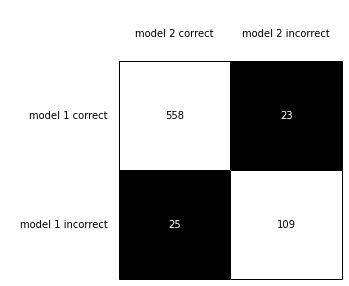

In [86]:
print('Base + LIWC vs Fine tuned + Empath')
testsig(y_test, y_pred_b, y_pred, alpha=0.05)

Our final model is not better than the one Knežević et al. used.

Fine tuned + LIWC vs Fine tuned + Empath
statistic=0.071, p-value=0.789
Same proportions of errors (fail to reject H0)


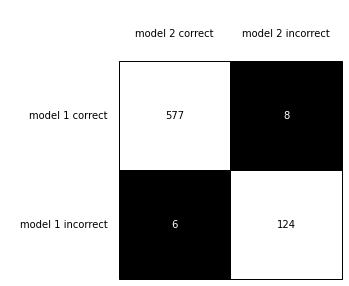

In [87]:
print('Fine tuned + LIWC vs Fine tuned + Empath')
testsig(y_test, y_pred_l, y_pred, alpha=0.05)

Empath features can replace LIWC features.

### Error analysis

In [88]:
indexes = []
predictions = []
for index, (first, second) in enumerate(zip(y_test, y_pred)):
    if first != second:
        indexes.append(index)
        predictions.append(second)
        
indexes2 = []
predictions2 = []
for index, (first, second) in enumerate(zip(y_test, y_pred_l)):
    if first != second:
        indexes2.append(index)
        predictions2.append(second)

In [89]:
sum(predictions)/len(predictions)

0.7651515151515151

In [90]:
sum(predictions2)/len(predictions2)

0.7384615384615385

In [91]:
test_ex = pd.read_csv('dreaddit-test.csv')[['text', 'label']]
for i in indexes:
    if i not in indexes2:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                         text  label
158  I assumed she would answer the question, or she would explore my feelings of inadequacy, or she would interpret the transference. But her response instead was the title "I am not getting into this with you". She then went on with how she did like me, thought I was an interesting and nice person. but I do not believe that, it is too unlikely. Besides, as an addendum to her refusal to speak to my question, it seemed false.      0
                                                                                                                              

In [92]:
test_ex = pd.read_csv('dreaddit-test.csv')[['text', 'label']]
for i in indexes2:
    if i not in indexes:
        print(test_ex.loc[[i]].to_string())

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    text  label
96  My sister is an alcoholic, which is something that seems to run in the family. Everytime my mother invites her over to spend the night, she has to hide all her beer and wine in a futile attempt to keep my sister from drinking it all. However, my sister always sneaks alcohol into the house anyway, and is drunk by nightfall. Then the arguments start. Usually they start over something like dinner not being done soon eno

In [93]:
inter = np.intersect1d(indexes, indexes2)
suma = 0
for i in inter:
    print(test_ex.loc[[i]].to_string())
    suma += test_ex['label'].iloc[i]

                                                                                                                                                                                                                                                                                                                                                                           text  label
12  PTSD is life changing for the worse. Every day fight. Getting in a fist fight in high school( who did not get into a fight)  I'm not talking about bullying,  Playing video games,  having bad dreams does not cause PTSD. We have seen things, or done things or ,been part of things,  that most people will never understand and hopefully never experience. End of Rant      1
                                                                                                                                                                                                                                                          

531  I also added up the value of everything I can possibly remember that's either missing or destroyed, and it reaches over 2,100 dollars...and that's a lenient estimate, I definitely rounded down. But I'd love to charge another grand for mental anguish or whatever. The whole ordeal has been like Trigger-City for someone like me who is struggling to recover from mental illnesses and over a year and 9 months clean after 10-12 years of substance abuse. I'm also receiving supportive services from a county program aimed at helping mentally "screwed up" people become independent, for lack of a better term. What's cool about the service is that I get a case manager who I can call for advice and in turn checks on me and referred me to a halfway house which only lasts 30 days but it's much better than having to stay at the local shelter, which might be my only option come June...      1
                                                                                                           